## Preprocessament dels conjunts de dades

In [ ]:
! pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\jesus\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [ ]:
from ydata_profiling import ProfileReport
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

Tranformar Dataset (Eliminació i canvi del ordre de les columnes, canvi del noms dels atributs, canvi del tipus de dades)

In [ ]:
def check_and_transform_csv(file_path, output_path, column_mapping):
    
    expected_columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

    # Carregar el CSV correctament
    df = pd.read_csv(file_path)
    
    # Comprovar si ja té el format correcte
    if list(df.columns) == expected_columns:
        print("El CSV ja té el format correcte. No s'han fet canvis.")
        return
    
    # Verificar que totes les columnes de mapping existeixen al CSV
    if not set(column_mapping.keys()).issubset(set(df.columns)):
        raise ValueError("Algunes columnes del mapping no existeixen en el CSV proporcionat. Revisa les dades d'entrada.")
    
    # Renombrar les columnes segons el mapping proporcionat
    df.rename(columns=column_mapping, inplace=True)
    
    # Reordenar les columnes segons el format esperat
    df = df[expected_columns]
    
    
    # Guardar el nou CSV
    df.to_csv(output_path, index=False)
    print(f"CSV transformat i guardat a {output_path}")


column_mapping = {"Fecha": "Date", "Apertura": "Open", "Máximo": "High", "Mínimo": "Low", "Último": "Close", "Vol.": "Volume"}
check_and_transform_csv("Amazon_Stock_Price.csv", "Amazon_Stock_Price_output.csv", column_mapping)


CSV transformat i guardat a Amazon_Stock_Price_output.csv


In [ ]:
def transform_dtypes(df):
    # Comprovar si la columna 'Date' ja és de tipus datetime
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        # Convertir la columna "Date" a datetime amb el format correcte (dia.mes.any)
        df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y', errors='coerce')
        
    # Classificar les dates en ordre ascendent
    df = df.sort_values(by='Date', ascending=True).reset_index(drop=True)

    # Comprovar si les columnes 'Open', 'Close', 'Low', 'High' són numèriques
    for col in ['Open', 'Close', 'Low', 'High']:
        if not pd.api.types.is_numeric_dtype(df[col]):
            # Substituir les comes per punts en les columnes de preus
            df[col] = df[col].replace({',': '.'}, regex=True)
            # Convertir les columnes a numèrics
            df[col] = pd.to_numeric(df[col])

    # Comprovar si la columna 'Volume' és numèrica
    if not pd.api.types.is_numeric_dtype(df['Volume']):
        # Substituir les comes per punts i eliminar la "M"
        df['Volume'] = df['Volume'].replace({',': '.'}, regex=True)
        df['Volume'] = df['Volume'].str.replace('M', '').astype(float) * 1_000_000  # Convertir a milions

    return df

df = pd.read_csv("Amazon_Stock_Price_output.csv")
df = transform_dtypes(df)
print(df.head())


        Date   Open   High    Low  Close      Volume
0 2020-01-02  93.75  94.90  93.21  94.90  80720000.0
1 2020-01-03  93.22  94.31  93.22  93.75  75330000.0
2 2020-01-06  93.00  95.18  93.00  95.14  81310000.0
3 2020-01-07  95.22  95.69  94.60  95.34  82680000.0
4 2020-01-08  94.90  95.55  94.32  94.60  70240000.0


Crear informe complet del Dataset

In [ ]:
def Report(df):

    profile = ProfileReport(df, title="Pandas Profiling Report")
    profile.to_file("report.html")

Report(df)

Export report to file: 100%|██████████| 1/1 [00:00<?, ?it/s]


Crear gàafiques per veure l'evolució dels preus en un període de temps. 

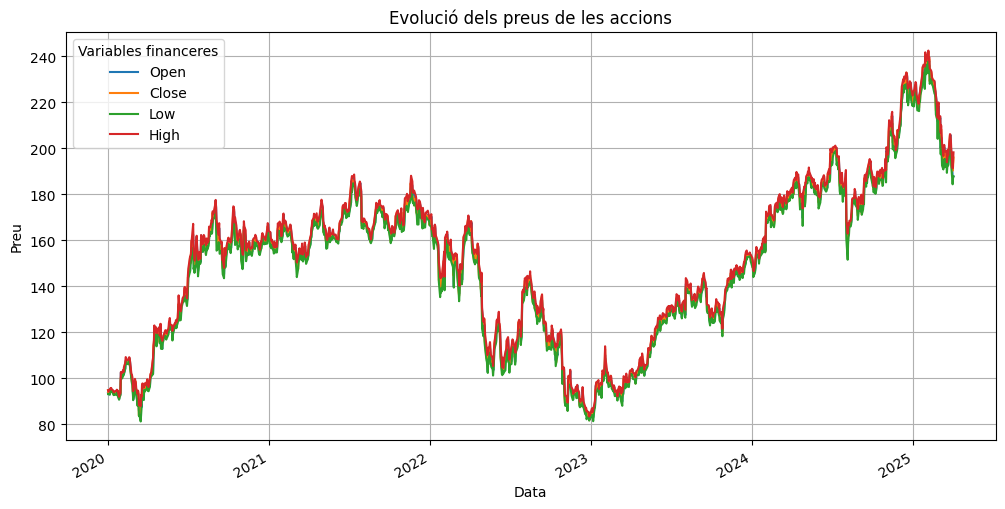

<Figure size 640x480 with 0 Axes>

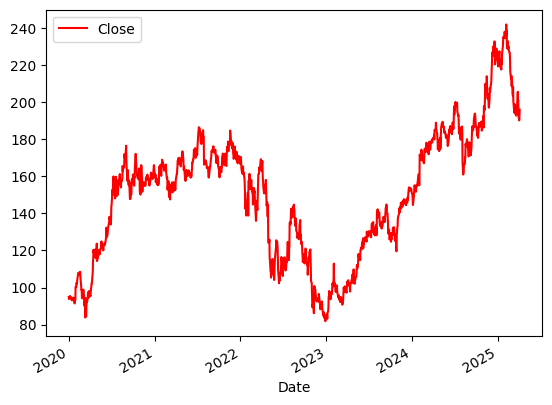

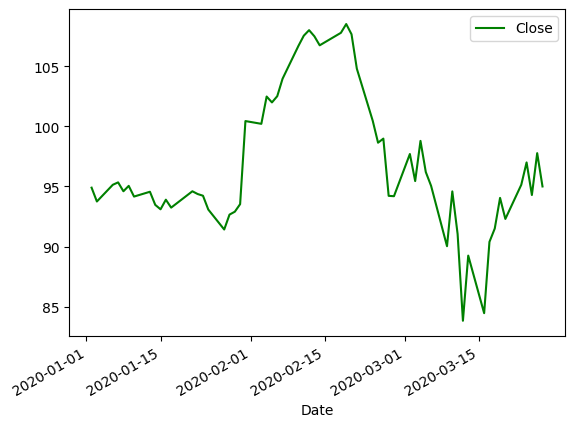

<Figure size 640x480 with 0 Axes>

In [ ]:
def graph(df):
    # Crear una còpia del dataframe amb "Date" com a índex, però sense eliminar la columna original
    trainCSV_indexed = df.set_index('Date', drop=False)

    # Representar gràficament les columnes Open, Close, Low i High amb la data com a eix X
    trainCSV_indexed[['Open', 'Close', 'Low', 'High']].plot(figsize=(12, 6), grid=True)

    # Afegir títol i etiquetes als eixos
    plt.title('Evolució dels preus de les accions')
    plt.xlabel('Data')
    plt.ylabel('Preu')
    plt.legend(title="Variables financeres")  # Afegir llegenda

    # Mostrar el gràfic
    plt.show()

    # Desar el gràfic com a imatge
    plt.savefig('grafic_accions.png')

    # Representar gràficament la data versus el preu de tancament (Close) en vermell
    df.plot('Date', 'Close', color="red")

    # Extreure només les 60 primeres files per fer el gràfic més clar
    new_data = df.head(60)

    # Representar gràficament la data versus el preu de tancament (Close) amb les 60 primeres files en verd
    new_data.plot('Date', 'Close', color="green")

    # Mostrar el gràfic
    plt.show()

    # Desar aquest segon gràfic com a imatge
    plt.savefig('grafic_accions_close.png')

graph(df)

Identificar outliers

In [ ]:

# Identificar les columnes numèriques per comprovar si hi ha valors atípics
numeric_columns = df.select_dtypes(include=['float64']).columns

# Detectar valors atípics utilitzant el mètode del rang interquartílic (IQR)
for column in numeric_columns:
    Q1 = df[column].quantile(0.25)  # Primer quartil
    Q3 = df[column].quantile(0.75)  # Tercer quartil
    IQR = Q3 - Q1  # Rang interquartílic
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]  # Condició per a valors atípics
    print(f"Valors atípics a la columna {column}: {len(outliers)}")


Valors atípics a la columna Open: 0
Valors atípics a la columna High: 0
Valors atípics a la columna Low: 0
Valors atípics a la columna Close: 0
Valors atípics a la columna Volume: 67


#### Feature Engineering (Creació de variables).

In [ ]:
# Funció per calcular la mitjana mòbil exponencial (EMA)
def exponential_moving_average(data, period):
    data = np.asarray(data)  # Convertir les dades a un array de NumPy
    alpha = 2 / (period + 1)  # Càlcul del factor de suavitzat (alpha)
    ema = np.empty_like(data)  
    ema[0] = data[0]  # El primer valor de l'EMA és igual al primer valor de les dades

    # Càlcul iteratiu de l'EMA per a cada punt
    for i in range(1, len(data)):
        ema[i] = alpha * data[i] + (1 - alpha) * ema[i - 1]

    return ema  

# Funció per visualitzar el preu i les mitjanes mòbils exponencials
def graphic_exponential_moving_average(df):
    plt.figure(figsize=(14, 6)) 

    # Determinar si "Date" és una columna o l'índex per usar-la com a eix X
    if 'Date' in df.columns:
        x = df['Date']
    else:
        x = df.index

    # Dibuixar el preu de tancament
    plt.plot(x, df['Close'], label='Preu de tancament', alpha=0.5)

    # Dibuixar l'EMA de 7 dies (més sensible als canvis)
    plt.plot(x, df['EMA_7'], label='EMA 7 dies', linestyle='--')

    # Dibuixar l'EMA de 40 dies (més suau i lenta)
    plt.plot(x, df['EMA_40'], label='EMA 40 dies', linestyle='--')

    plt.xlabel('Data')
    plt.ylabel('Preu')
    plt.title('Preu de tancament i mitjanes mòbils exponencials')
    plt.legend()
    plt.grid(True)
    plt.show()  


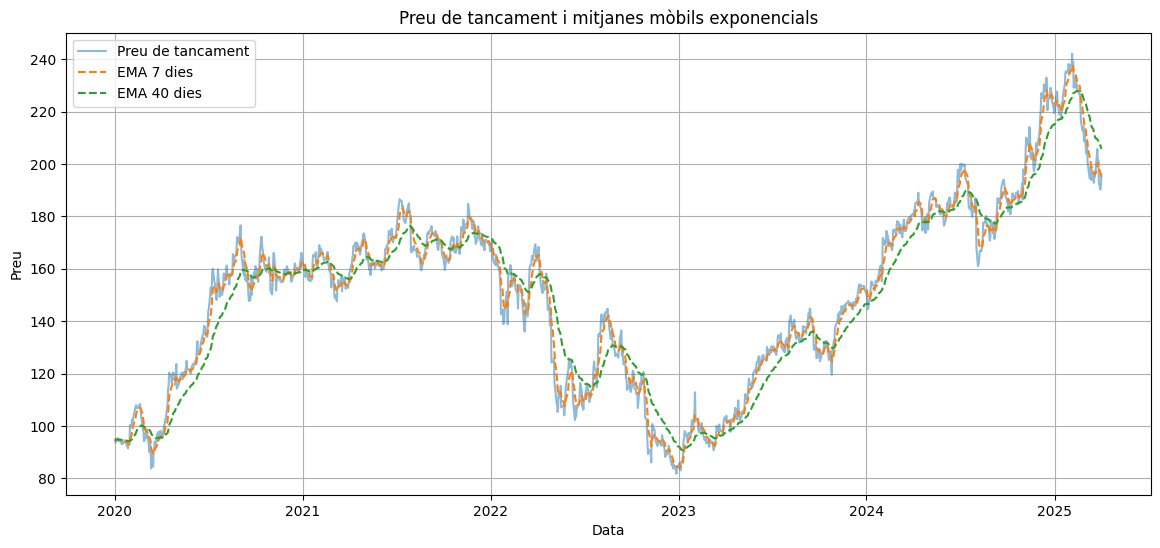

In [ ]:

df['EMA_7'] = exponential_moving_average(df['Close'], 7)
df['EMA_40'] = exponential_moving_average(df['Close'], 40)
graphic_exponential_moving_average(df)

In [ ]:
# Funció per calcular el MACD, la línia de senyal i l'histograma
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    
    # Calcular la mitjana mòbil exponencial curta i llarga del preu de tancament
    ema_short = exponential_moving_average(df['Close'], short_period)
    ema_long = exponential_moving_average(df['Close'], long_period)

    # Calcular el MACD com la diferència entre les dues EMAs
    macd = ema_short - ema_long

    # Calcular la línia de senyal (mitjana suau del MACD)
    signal_line = exponential_moving_average(macd, signal_period)

    # Calcular l'histograma com la diferència entre el MACD i la línia de senyal
    macd_hist = macd - signal_line

    # Afegir les columnes resultants al DataFrame
    df['MACD'] = macd
    df['Signal_Line'] = signal_line
    df['MACD_Hist'] = macd_hist

    return df

# Funció per visualitzar el MACD, la línia de senyal i l'histograma
def calculate_macd_graph(df):
    # Verifiquem si la columna "Date" existeix per utilitzar-la a l'eix X
    if 'Date' in df.columns:
        x = df['Date']
    else:
        x = df.index  # Si no, usem l'índex (suposadament dates també)

    # Crear una nova figura per plotejar
    plt.figure(figsize=(14,6))

    # Dibuixar la línia del MACD
    plt.plot(x, df['MACD'], label='MACD', color='blue')

    # Dibuixar la línia de senyal
    plt.plot(x, df['Signal_Line'], label='Línia de senyal', color='orange')

    # Dibuixar l'histograma (com barres)
    plt.bar(x, df['MACD_Hist'], label='Histograma', color='gray', alpha=0.3)

    plt.title('MACD')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()


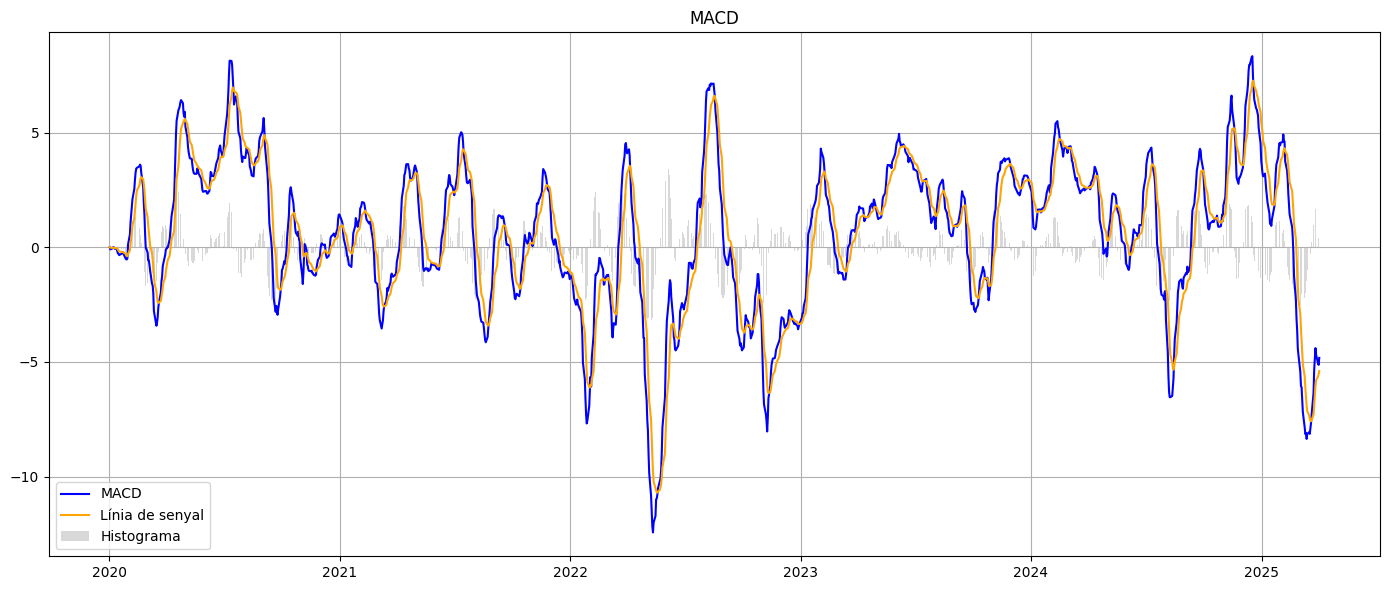

In [ ]:

df = calculate_macd(df)
calculate_macd_graph(df)


In [ ]:
import numpy as np
import pandas as pd

# Calcula l'RSI utilitzant l'exponential weighted moving average (EWM) i afegeix una columna "RSI" al DataFrame.
def calculate_rsi_ewm(df, period=14):
    
    delta = df['Close'].diff()  # Calcular la variació diària del preu de tancament

    # Calcular els guanys i les pèrdues: els guanys són les variacions positives, les pèrdues són les negatives (en valor absolut)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Calcular la mitjana exponencial dels guanys i les pèrdues.
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()

    # Calcular la força relativa (RS)
    rs = avg_gain / avg_loss

    # Calcular l'RSI
    rsi = 100 - (100 / (1 + rs))

    df['RSI'] = rsi
    
    return df

df = calculate_rsi_ewm(df, period=14)


In [ ]:
import pandas as pd
import numpy as np

#Calcula l'ATR (Average True Range) utilitzant el càlcul recursiu de Wilder.
def calculate_atr_recursive(df, period=14):
 
    # Calcular el True Range (TR)
    high_low = df['High'] - df['Low']
    high_prev_close = abs(df['High'] - df['Close'].shift(1))
    low_prev_close = abs(df['Low'] - df['Close'].shift(1))
    tr = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
    
    atr_values = []  # Llista on anirem emmagatzemant els valors d'ATR
    
    # Per a les primeres 'period' files no es pot calcular ATR de manera recursiva
    for i in range(len(tr)):
        if i < period:
            atr_values.append(np.nan)  # Assignem NaN fins que tinguem suficients dades
        elif i == period:
            # Primer valor d'ATR: mitjana simple dels TR dels primers 'period' dies
            initial_atr = tr.iloc[i - period + 1:i + 1].mean()
            atr_values.append(initial_atr)
        else:
            # Calcular l'ATR recursiu
            atr_today = ((atr_values[i - 1] * (period - 1)) + tr.iloc[i]) / period
            atr_values.append(atr_today)
    
    df['ATR'] = atr_values
    return df


df = calculate_atr_recursive(df, period=14)


In [ ]:
#Imputar els valors NaN amb el primer valor vàlid.
df['RSI'] = df['RSI'].fillna(method='bfill')  
df['ATR'] = df['ATR'].fillna(method='bfill')

C:\Users\jesus\AppData\Local\Temp\ipykernel_5072\1478090778.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['RSI'] = df['RSI'].fillna(method='bfill')  # Omple cap endavant
C:\Users\jesus\AppData\Local\Temp\ipykernel_5072\1478090778.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ATR'] = df['ATR'].fillna(method='bfill')


Guardar el dataset amb tots els canvis.

In [ ]:
df.to_csv("Amazon_Stock_Price_final.csv", index=False)